In [1]:
import os
import re
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump
from pprint import pprint
from dotenv import dotenv_values

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

from statistics import (fmean, 
                        stdev)

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

# for encoding categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder)


In [2]:
# Directories and wandb setup
DATA_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"
PROJECT_ENV = dotenv_values("config/project.env")
PROJECT = PROJECT_ENV["project"]
ENTITY = PROJECT_ENV["entity"]
os.environ['WANDB_NOTEBOOK_NAME'] = os.path.join(os.getcwd(), "ProjectStage2.ipynb")

wandb.login();

wandb: Currently logged in as: nclgbd (use `wandb login --relogin` to force relogin)


In [3]:
# load the data - it is available open source and online
data = pd.read_csv(DATA_DIR)
test_data = pd.read_csv(TEST_DIR)
new_columns_dict = dict(zip(data.columns, [col.lower() for col in data.columns]))
data = data.rename(columns=new_columns_dict)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data = data.replace('?', np.nan)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Feature Engineering
Recall from the last notebook, there we used a method to see the correlation between two different features, specifically to see how predictive certain features were for predicting survival. To take advantage of this, we'll create some new features for predicting instead:

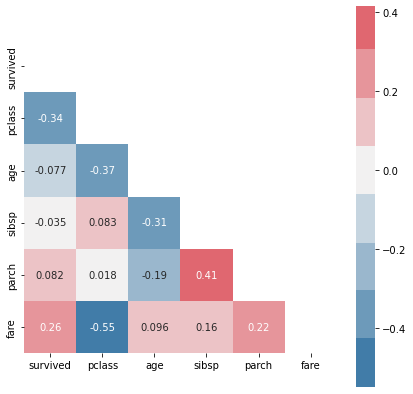

In [8]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
data_no_pid = data.drop(columns="passengerid")
data_corr = data_no_pid.corr()
mask = np.triu(np.ones_like(data_corr, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9)

plt.figure(figsize=(7,7))
sns.heatmap(data_corr, mask=mask, center=0,
            square=True, cmap=palette, annot=True)
plt.show()

## Creating new features

In [9]:
# retain only the first cabin if more than
# 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)
data['cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in data['cabin']])
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S


In [10]:
data["age"] = data["age"].replace(np.nan, data["age"].median())
data.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
def create_age_group(age):
    if age > 66:
        return 6
    elif age > 40:
        return 5
    elif age > 33:
        return 4
    elif age > 27:
        return 3
    elif age > 22:
        return 2
    elif age > 18:
        return 1
    else:
        return 0

data['agegroup'] = data['age'].apply(create_age_group)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4


In [12]:
data["relatives"] = data['sibsp'] + data["parch"]
def create_is_single():
    if data["relatives"] > 0:
        return 0
    else:
        return 1
    
data['single'] = data["relatives"].apply(create_age_group)
data = data.drop(["relatives"], axis=1)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup,single
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4,0


In [13]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup,single,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4,0,Mr


In [14]:
data['embarked'].fillna(value='S', inplace=True)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup,single,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4,0,Mr


In [15]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    # Extract fist letter of variable
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        # so that we do not over-write the original dataframe
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = X[feature].str[0]

        return X

In [16]:
# list of variables to be used in the pipeline's transformers
NUMERICAL_VARIABLES = ['age', 'fare']
CATEGORICAL_VARIABLES = ['sex', 'cabin', 'embarked', "title"]
CABIN = ["cabin"]

# drop unnecessary variables
data = data.drop(labels=['name', 'ticket'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   sex          891 non-null    object 
 4   age          891 non-null    float64
 5   sibsp        891 non-null    int64  
 6   parch        891 non-null    int64  
 7   fare         891 non-null    float64
 8   cabin        891 non-null    object 
 9   embarked     891 non-null    object 
 10  agegroup     891 non-null    int64  
 11  single       891 non-null    int64  
 12  title        891 non-null    object 
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


# Training Approach 1: Basic Defaults
Here we're going to define a naive approach to training the model: guess and check! Using `StratifiedKFold`, we'll evaluate how well our model trains based on the accuracy and standard deviation.

In [17]:
def _train(model_name, X, y, train_idx, valid_idx, config=None, verbose=0):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    model = make_model(model_name, config, verbose=verbose)

    # split the data
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # set up the pipeline
    titanic_pipe = Pipeline([
        # ===== IMPUTATION =====
        # impute categorical variables with string missing
        ('categorical_imputation', CategoricalImputer(
            imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

        # add missing indicator to numerical variables
        ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

        # impute numerical variables with the median
        ('median_imputation', MeanMedianImputer(
            imputation_method='median', variables=NUMERICAL_VARIABLES)),
    
        # Extract letter from cabin
        ('extract_letter', ExtractLetterTransformer(variables=CABIN)),

        # == CATEGORICAL ENCODING ======
        # remove categories present in less than 5% of the observations (0.05)
        # group them in one category called 'Rare'
        ('rare_label_encoder', RareLabelEncoder(
            tol=0.05, n_categories=1, variables=CATEGORICAL_VARIABLES)),

        # encode categorical variables using one hot encoding into k-1 variables
        ('categorical_encoder', OneHotEncoder(
            drop_last=True, variables=CATEGORICAL_VARIABLES)),

        # scale
        ('scaler', StandardScaler()),

        # predict
        (model_name, model),
    ])
    
    titanic_pipe.fit(X_train, y_train)
    y_probas = titanic_pipe.predict_proba(X_valid)
    y_pred = titanic_pipe.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred)
    
    return (titanic_pipe, 
            y_valid, y_probas, y_pred, 
            accuracy, precision, recall, f1, auc)
        

In [18]:
def train(model_name, X, y, dry_run=True, config=None, verbose=0):
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores = []
    best_model: Pipeline
    highest_acc = -1
    
    # USING SKLEARN, NO HYPERPARAMETER SEARCH
    if dry_run:
        for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
            (titanic_pipe, 
            y_valid, y_probas, y_pred, 
            accuracy, precision, recall, f1, auc) = _train(model_name, X, y, train_idx, valid_idx, config, verbose)
            
            print(classification_report(y_valid, y_pred))
            cm = confusion_matrix(y_valid, y_pred)
            cm_plot = ConfusionMatrixDisplay(cm, display_labels=titanic_pipe.classes_)
            cm_plot.plot()
            plt.show(cm_plot)
            
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            auc_scores.append(auc)
            
            if highest_acc < 0: # first run, just set it
                best_model = titanic_pipe
            else:
                best_model = best_model if highest_acc > accuracy else titanic_pipe
            
            highest_acc = max(highest_acc, accuracy)
        
        print(f"Average Mean: {fmean(accuracies):.5f} +/- {stdev(accuracies):.4f}")
        print(f"Average Precision: {fmean(precisions):.5f} +/- {stdev(precisions):.4f}")
        print(f"Average Recall: {fmean(recalls):.5f} +/- {stdev(recalls):.4f}")
        print(f"Average F1 Score: {fmean(f1_scores):.5f} +/- {stdev(f1_scores):.4f}")
        print(f"Average AUC Score: {fmean(auc_scores):.5f} +/- {stdev(auc_scores):.4f}")
                
        
    # USING WEIGHTS AND BIASES      
    else:
        run = wandb.init(project=PROJECT, 
                        entity=ENTITY, 
                        config=config,
                        reinit=True)
        
        with run:
            model_filepath = os.path.join(os.getcwd(), "models")
            avg_metrics_dict = {}
            column_names = ["accuracy", "precision", "recall", "f1", "auc"]
            
            for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
                config = run.config
                model_id = "".join([str(idx+1), "_", str(run.id)])
                
                (titanic_pipe, 
                y_valid, y_probas, y_pred, 
                accuracy, precision, recall, f1, auc) = _train(model_name, X, y, train_idx, valid_idx, config, verbose)
                
                pr = wandb.plot.pr_curve(y_valid, y_probas)
                wandb.log({f"pr_curve": pr})
                
                cm = confusion_matrix(y_valid, y_pred)
                wandb.log({f"confusion matrix [{model_id}]": wandb.Table(columns=["died", "survived"],
                                                                         rows=["died", "survived"],
                                                                         data=cm)})
            
                accuracies.append(accuracy)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                auc_scores.append(auc)
                
                if highest_acc < 0: # first run, just set it
                    best_model = titanic_pipe
                else:
                    best_model = best_model if highest_acc > accuracy else titanic_pipe
                
                highest_acc = max(highest_acc, accuracy)
                
            # Log metrics using wandb  
            avg_metrics_dict["avg_acc"] = fmean(accuracies)  
            avg_metrics_dict["avg_acc_std"] = stdev(accuracies)
            
            avg_metrics_dict["avg_precision"] = fmean(precisions)
            avg_metrics_dict["avg_precision_std"] = stdev(precisions)
            
            avg_metrics_dict["avg_recall"] = fmean(recalls)
            avg_metrics_dict["avg_recall_std"] = stdev(recalls)
            
            avg_metrics_dict["avg_f1_score"] = fmean(f1_scores)
            avg_metrics_dict["avg_f1_score_std"] = stdev(f1_scores)
            
            avg_metrics_dict["avg_auc_score"] = fmean(auc_scores)
            avg_metrics_dict["avg_auc_score_std"] = stdev(auc_scores)
            
            wandb.log(avg_metrics_dict)
            
            # Create a table of all the individual metrics
            wandb.log({f"performance_metrics_{run.id}]": wandb.Table(columns=column_names,
                                                                     data=[accuracies,
                                                                           precisions, 
                                                                           recalls, 
                                                                           f1_scores,
                                                                           auc_scores])})
            
            # Save the best model on wandb
            full_path = os.path.join(model_filepath, "".join([model_name.lower(),'.joblib']))
            dump(best_model, full_path)
            run.log_artifact(full_path, 
                             name=f"{model_name.lower()}", 
                             aliases=str(run.id), 
                             type="model")

In [19]:
rfc_config = {
    "n_estimators": 100,
    "min_samples_leaf": 10,
    "criterion": "gini"
}

logit_config = {
    "C": 0.0005,
    "max_iter": 100
}

In [20]:
def make_model(model_name, config, verbose=0):
    if model_name == "RFC":
        return RandomForestClassifier(n_estimators=config["n_estimators"],
                                      min_samples_leaf=config["min_samples_leaf"],
                                      criterion=config["criterion"],
                                      verbose=verbose,
                                      random_state=42)
        
    elif model_name == "Logit":
        return LogisticRegression(C=config["C"],
                                  max_iter=config["max_iter"],
                                  verbose=verbose,
                                  random_state=42)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.71      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



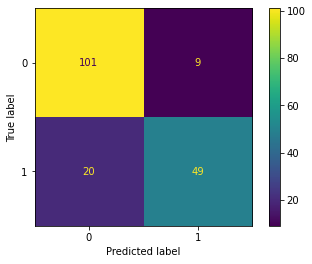

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.77      0.75      0.76        68

    accuracy                           0.82       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.82      0.82      0.82       178



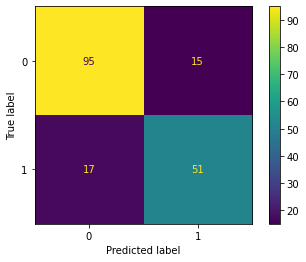

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.75        68

    accuracy                           0.82       178
   macro avg       0.81      0.80      0.81       178
weighted avg       0.82      0.82      0.82       178



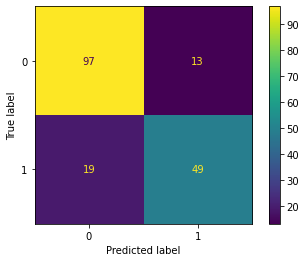

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       110
           1       0.80      0.57      0.67        68

    accuracy                           0.78       178
   macro avg       0.79      0.74      0.75       178
weighted avg       0.78      0.78      0.77       178



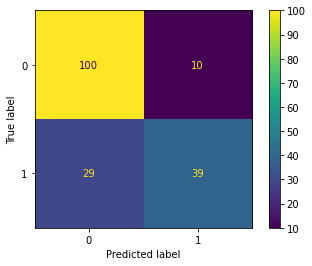

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       109
           1       0.85      0.72      0.78        69

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.83       178
weighted avg       0.84      0.84      0.84       178



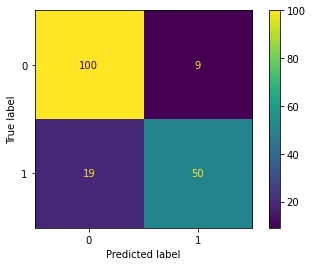

Average Mean: 0.82041 +/- 0.0243
Average Precision: 0.81025 +/- 0.0339
Average Recall: 0.69578 +/- 0.0699
Average F1 Score: 0.74692 +/- 0.0461
Average AUC Score: 0.79691 +/- 0.0320


In [21]:
train("RFC", data.drop('survived', axis=1), data['survived'], config=rfc_config)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       110
           1       1.00      0.07      0.14        69

    accuracy                           0.64       179
   macro avg       0.82      0.54      0.45       179
weighted avg       0.77      0.64      0.53       179



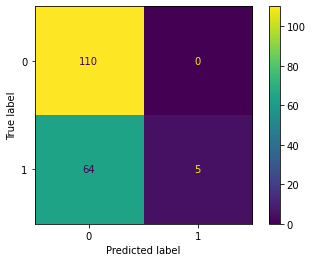

              precision    recall  f1-score   support

           0       0.68      0.98      0.81       110
           1       0.90      0.26      0.41        68

    accuracy                           0.71       178
   macro avg       0.79      0.62      0.61       178
weighted avg       0.77      0.71      0.65       178



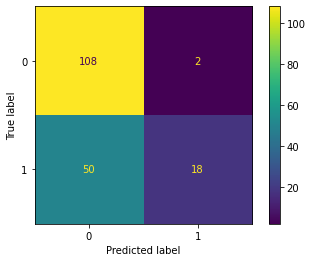

              precision    recall  f1-score   support

           0       0.65      0.99      0.79       110
           1       0.91      0.15      0.25        68

    accuracy                           0.67       178
   macro avg       0.78      0.57      0.52       178
weighted avg       0.75      0.67      0.58       178



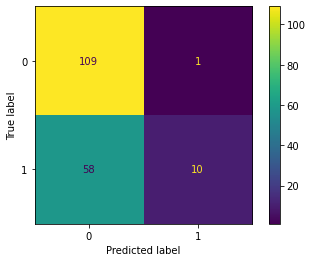

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       110
           1       1.00      0.13      0.23        68

    accuracy                           0.67       178
   macro avg       0.83      0.57      0.51       178
weighted avg       0.78      0.67      0.58       178



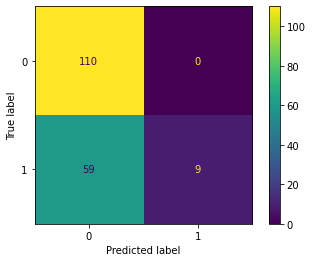

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       109
           1       1.00      0.12      0.21        69

    accuracy                           0.66       178
   macro avg       0.82      0.56      0.49       178
weighted avg       0.78      0.66      0.56       178



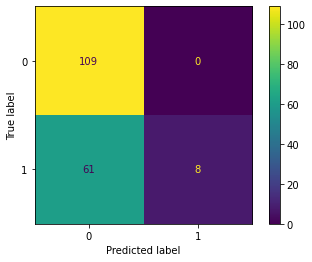

Average Mean: 0.66894 +/- 0.0242
Average Precision: 0.96182 +/- 0.0524
Average Recall: 0.14650 +/- 0.0717
Average F1 Score: 0.24779 +/- 0.1007
Average AUC Score: 0.57053 +/- 0.0322


In [22]:
train("Logit", data.drop('survived', axis=1), data['survived'], config=logit_config)

# Defining Hyperparameter Sweeps with Weights and Biases

In [31]:
# Initialize random forest sweep
rfc_sweep_config = {
    "method": "random"
}

metric = {
    "name": "avg_acc",
    "goal": "maximize"
}

parameters = {
    "n_estimators": {
        "distribution": "int_uniform",
        "min": 5000,
        "max":10000
        },
    
    "criterion" : {
        "values": ["gini", "entropy"]
        },
    
    "min_samples_leaf" : {
        "value": 1
        }
}

rfc_sweep_config["metric"] = metric
rfc_sweep_config["parameters"] = parameters
pprint(rfc_sweep_config)

rfc_sweep_id = wandb.sweep(rfc_sweep_config, 
                           project=PROJECT, 
                           entity=ENTITY)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'avg_acc'},
 'parameters': {'criterion': {'values': ['gini', 'entropy']},
                'min_samples_leaf': {'value': 1},
                'n_estimators': {'distribution': 'int_uniform',
                                 'max': 10000,
                                 'min': 5000}}}
Create sweep with ID: xkhkpl38
Sweep URL: https://wandb.ai/nclgbd/Titanic-Classification/sweeps/xkhkpl38


In [24]:
# Initialize logistic regression sweep
logit_sweep_config = {
    "method": "random"
}

metric = {
    "name": "avg_acc",
    "goal": "maximize"
}

parameters = {
    "C": {
        "values": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    },
    "max_iter": {
        "values": [100, 500, 1000]
    }
}

logit_sweep_config["metric"] = metric
logit_sweep_config["parameters"] = parameters
pprint(logit_sweep_config)

logit_sweep_id = wandb.sweep(logit_sweep_config, 
                             project=PROJECT, 
                             entity=ENTITY)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'avg_acc'},
 'parameters': {'C': {'values': [0.0001,
                                 0.0005,
                                 0.001,
                                 0.005,
                                 0.01,
                                 0.05,
                                 0.1,
                                 0.5,
                                 1]},
                'max_iter': {'values': [100, 500, 1000]}}}
Create sweep with ID: 94z5dtpt
Sweep URL: https://wandb.ai/nclgbd/Titanic-Classification/sweeps/94z5dtpt


In [25]:
def sweep_rfc(config=None):
    train("RFC", data.drop('survived', axis=1), data['survived'], dry_run=False, config=config)

In [26]:
def sweep_logit(config=None):
    train("Logit", data.drop('survived', axis=1), data['survived'], dry_run=False, config=config)

In [32]:
wandb.agent(rfc_sweep_id, sweep_rfc, 
            project=PROJECT, entity=ENTITY, 
            count=10)

wandb: Agent Starting Run: ch7j3fyw with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 9795
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81259


wandb: Agent Starting Run: bsnykzvj with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 8145
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81034


wandb: Agent Starting Run: sdrd48mt with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 5297
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81371


wandb: Agent Starting Run: l04qb8b0 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 7261
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81147


wandb: Agent Starting Run: ig3ti6vc with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 9639
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81147


wandb: Agent Starting Run: viiwla7f with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 8224
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81371


wandb: Agent Starting Run: anh07gh7 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 9849
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81147


wandb: Agent Starting Run: nabfhygd with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 5485
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81036


wandb: Agent Starting Run: uv73a34o with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 5328
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81371


wandb: Agent Starting Run: aj6ton88 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	n_estimators: 7879
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.81147


In [28]:
wandb.agent(logit_sweep_id, sweep_logit, 
            project=PROJECT, entity=ENTITY, 
            count=10)

wandb: Agent Starting Run: zxpbpk99 with config:
wandb: 	C: 0.05
wandb: 	max_iter: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80918


wandb: Agent Starting Run: cy8vv66e with config:
wandb: 	C: 0.5
wandb: 	max_iter: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80131


wandb: Agent Starting Run: 0dxkilii with config:
wandb: 	C: 0.1
wandb: 	max_iter: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80694


wandb: Agent Starting Run: 2eb88dbm with config:
wandb: 	C: 0.001
wandb: 	max_iter: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.73629


wandb: Agent Starting Run: bv3zzocf with config:
wandb: 	C: 0.05
wandb: 	max_iter: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80918


wandb: Agent Starting Run: 1khpsviu with config:
wandb: 	C: 0.001
wandb: 	max_iter: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.73629


wandb: Agent Starting Run: ebp125wp with config:
wandb: 	C: 0.001
wandb: 	max_iter: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.73629


wandb: Agent Starting Run: lsi6kn4k with config:
wandb: 	C: 0.005
wandb: 	max_iter: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80472


wandb: Agent Starting Run: 4ibl7v93 with config:
wandb: 	C: 0.005
wandb: 	max_iter: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80472


wandb: Agent Starting Run: tj8fld6k with config:
wandb: 	C: 0.1
wandb: 	max_iter: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


avg_acc,▁
avg_acc_std,▁
avg_auc_score,▁
avg_auc_score_std,▁
avg_f1_score,▁
avg_f1_score_std,▁
avg_precision,▁
avg_precision_std,▁
avg_recall,▁
avg_recall_std,▁
avg_acc,0.80694
